# Lab | Introduction to LoRA Tuning using PEFT from Hugging Face
<!-- ### Fine-tune a Foundational Model effortlessly -->

**Note:** This is more or less the same notebook you saw in the previous lesson, but that is ok. This is an LLM fine-tuning lab. In class we used a set of datasets and models, and in the labs you are required to change the LLMs models and the datasets including the pre-processing pipelines.


# LoRA Tuning

In this notebook you are being introduced to how to apply LoRA Tuning with the PEFT library to a pre-trained model.

For a complete list of Models compatible with PEFT refer to their [documentation](https://huggingface.co/docs/peft/main/en/index#supported-methods).

A short sample of models families available to be trained with PEFT are: Bloom, Llama, GPT-J, GPT-2, BERT... and more. Hugging Face is working hard to bring more Models to the Library.

## Brief introduction to LoRA Tuning.
LoRA is a re-parameterization technique. Its operation is simple, complex, and brilliant at the same time. It involves reducing the size of the matrices to be trained by dividing them in such a way that when multiplied, they yield the original matrix.

The weights that are modified are those of the reduced matrices, not the original matrix. It's better visualized in an image.

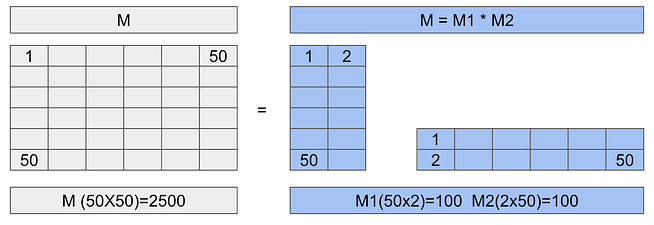

We have an original matrix of 50x50, which means we would have to modify about 2500 parameters. However, as we know, if we multiply two matrices of (2x50) and (50x2), we obtain a 50x50 matrix. Yet, these two matrices are formed by only 100 parameters each. In other words, for the reduced matrices, we need to modify a total of 200 parameters compared to the 2500 of the original matrix. This represents a 92% reduction, and the larger the original matrix, the greater the percentage of savings.

In Language Models like GPT-3 or any of the current ones with LoRA, it's possible that we only need to train about 0.02% of the original parameters. This varies for each model. The best part is that the obtained result is very similar to that of full fine-tuning, in some cases, it can even be better.

# Load the PEFT and Datasets Libraries.

The PEFT library contains the Hugging Face implementation of differente fine-tuning techniques, like LoRA Tuning.

Using the Datasets library we have acces to a huge amount of Datasets.

In [ ]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

From the transformers library we import the necesary classes to import the model and the tokenizer.

Then we can load the Tokenizer and the model.

Bloom is one of the smallest and smarter model available to be trained with PEFT Library using Prompt Tuning. You can use either of the models in the Bloom Family, I encorage you to use at least two of them and see the differences.

I'm using the smallest one just to spend less time trainig, and avoid memory problems in Colab.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloom-560m"

tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

KeyboardInterrupt: 

## Inference with the pre-trained model.
I'm going to do a test with the pre-trained model without fine-tuning, to see if something changes after the fine-tuning.

In [ ]:
#this function returns the outputs from the model received, and inputs.
def get_outputs(model, inputs, max_new_tokens=100): #play with this function inputs and see if you get something interesting
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5, #Avoid repetition.
        early_stopping=True, #The model can stop before reach the max_length
        eos_token_id=tokenizer.eos_token_id
    )
    return outputs

The dataset used for the fine-tuning contains prompts to be used with Large Language Models.

I'm going to request the pre-trained model that acts like a motivational coach.

In [ ]:
#Inference original model
input_sentences = tokenizer("can you be a motivational coach", return_tensors="pt")
foundational_outputs_sentence = get_outputs(foundation_model, input_sentences, max_new_tokens=50)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['can you be a motivational coach? If so, please let me know what kind of coaching services are available for your organization. I would love to hear from you:\nI am an experienced and qualified trainer who has been in the field since 1995 with over 20 years experience as well.\n']


Not sure if the answer is correct or not, but for sure is not a prompt. We need to train our model if we want that acts like a prompt engineer.

# Preparing the Dataset.
The Dataset used is:

https://huggingface.co/datasets/fka/awesome-chatgpt-prompts

In [ ]:
from datasets import load_dataset
dataset = "fka/awesome-chatgpt-prompts"

#Create the Dataset to create prompts.
data = load_dataset(dataset)
data = data.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
train_sample = data["train"].select(range(50))

train_sample = train_sample.remove_columns('act')

display(train_sample)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'input_ids', 'attention_mask'],
    num_rows: 50
})

In [ ]:
print(train_sample[:1])

{'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'], 'input_ids': [[186402, 1152, 1306, 660, 72560, 28857, 167625, 84544, 20165, 376, 1002, 26168, 267, 30479, 17477, 613, 267, 120755, 238776, 17, 1387, 47881, 632, 427, 14565, 29866, 664, 368, 120755, 15, 16997, 4054, 136044, 375, 4859, 12, 427, 39839, 15, 9697, 1242, 375, 13614, 12, 3804, 427, 368, 2298, 5268, 109891, 368, 17477, 15, 530, 427, 11210, 4143, 7112, 11866, 368, 11011, 1620, 36320, 17, 21265,

# Fine-Tuning.
First is necesary create a LoRA config.


In [ ]:
# TARGET_MODULES
# https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220

import peft
from peft import LoraConfig, get_peft_model, PeftModel

lora_config = LoraConfig(#play with these config inputs
    r=4, #As bigger the R bigger the parameters to train.
    lora_alpha=1, # a scaling factor that adjusts the magnitude of the weight matrix. Usually set to 1
    target_modules=["query_key_value"], #You can obtain a list of target modules in the URL above.
    lora_dropout=0.05, #Helps to avoid Overfitting.
    bias="lora_only", # this specifies if the bias parameter should be trained.
    task_type="CAUSAL_LM"
)

The most important parameter is **r**, it defines how many parameters will be trained. As bigger the valuer more parameters are trained, but it means that the model will be able to learn more complicated relations between input and output.

Yo can find a list of the **target_modules** available on the [Hugging Face Documentation]( https://github.com/huggingface/peft/blob/39ef2546d5d9b8f5f8a7016ec10657887a867041/src/peft/utils/other.py#L220)

**lora_dropout** is like the commom dropout is used to avoid overfitting.

**bias** I was hesitating if use *none* or *lora_only*. For text classification the most common value is none, and for chat or question answering, *all* or *lora_only*.

**task_type**. Indicates the task the model is beign trained for. In this case, text generation.

### Create the PEFT model.



In [ ]:
peft_model = get_peft_model(foundation_model, lora_config)
print(peft_model.print_trainable_parameters())

trainable params: 393,216 || all params: 559,607,808 || trainable%: 0.07026635339584111
None


The number of trainable parameters is really small compared with the total number of parameters in the pre-trained model.

In [ ]:
#Create a directory to contain the Model
import os
working_dir = './'

output_directory = os.path.join(working_dir, "peft_lab_outputs")

In the TrainingArgs we inform the number of epochs we want to train, the output directory and the learning_rate.

In [ ]:
#Creating the TrainingArgs
import transformers
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir=output_directory,
    auto_find_batch_size=True, # Find a correct bvatch size that fits the size of Data.
    learning_rate= 3e-2, # Higher learning rate than full fine-tuning.
    num_train_epochs=2,
    use_cpu=True
)

Now we can train the model.
To train the model we need:


*   The PEFT Model.
*   The training_args
* The Dataset
* The result of DataCollator, the Dataset ready to be procesed in blocks.





In [ ]:
#This cell may take up to 15 minutes to execute.
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kristiankatt (kristiankatt-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=14, training_loss=5.517386300223214, metrics={'train_runtime': 1007.3614, 'train_samples_per_second': 0.099, 'train_steps_per_second': 0.014, 'total_flos': 21871163621376.0, 'train_loss': 5.517386300223214, 'epoch': 2.0})

In [ ]:
#Save the model.
peft_model_path = os.path.join(output_directory, f"lora_model")

trainer.model.save_pretrained(peft_model_path)

In [ ]:
#Load the Model.
loaded_model = PeftModel.from_pretrained(foundation_model,
                                        peft_model_path,
                                        is_trainable=False)

In [ ]:
print(foundational_outputs_sentence)


tensor([[   44,  4026,  1152,   427,  1769,   661,  2670, 22675,  3383, 67604,
           473,     2]])


In [ ]:
print(loaded_model)


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): BloomForCausalLM(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=3072, bias=False)
                )
                (lora_e

In [ ]:
input_sentences = tokenizer("Tell me a joke", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=50)
print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))


['Tell me a jokeIId\\big\n\n\nIndexFlagsFirstViralFileNewWarning:J’aiJ’ollectionVoilàEm\r\n  AchoJustJe"fileSegundoMeuijoFuiPorqueMoiPenseiVãoIsol_ClickMeI]NuncaMÌPeloTCrecSóabeiEDIT:HÉEstatFOLPrimerVaigN']


In [ ]:
print(training_dataset[:5])


NameError: name 'training_dataset' is not defined

## Inference the fine-tuned model.

In [ ]:
input_sentences = tokenizer("I want you to act as my motivational coach", return_tensors="pt")
foundational_outputs_sentence = get_outputs(loaded_model, input_sentences, max_new_tokens=100)

print(tokenizer.batch_decode(foundational_outputs_sentence, skip_special_tokens=True))

['I want you to act as my motivational coach I']


The result is amazing. Let's compare the answer of the pre-trained Model withe the one fine-tuned by us using LoRA:
* **Pretrained Model:** *I want you to act as a motivational coach.*  Don't be afraid of being challenged.
* **Fine-Tuned Model:** I want you to act as a motivational coach.  I will provide some information about someone\'s motivation and goals, but it should be your job  in order my first request – "I need someone who can help me find the best way for myself stay motivated when competing against others." My suggestion is “I have

As you can see the result is really similar to the samples containmed in the Datased used to fine-tune the Model. And we only trained the Model for 10 epochs and with a really small number of rows.

The results were nonsensical with Bloom, there may be issues with the configurations of the lora.

# Exercise

- Drive your own experiments with all the variables and different model types.
    - Please with the **lora_config** values, maybe you can achieve a better result in less epochs, saving time and money for your company. :-)
- Write a one page report
    - What did you learn?

# I am doing an experiment with the Bloom model and applying lora.

In [1]:
!pip install -q peft==0.8.2
!pip install -q datasets==2.16.1
!pip install ipywidgets==7.7.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Step 1 - Load base model - Bloom

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load Phi-1 model and tokenizer
model_name = "bigscience/bloom-560m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

step 2 - Load dataset

In [5]:
tokenizer.pad_token = tokenizer.eos_token  # Assigning the EOS token as the pad token


In [6]:
from datasets import load_dataset

# Load dataset
dataset_name = "fka/awesome-chatgpt-prompts"
data = load_dataset(dataset_name)

# Tokenize the dataset
def tokenize_function(samples):
    return tokenizer(samples["prompt"], padding="max_length", truncation=True)

data = data.map(tokenize_function, batched=True)

# Select a subset for faster training
train_sample = data["train"].select(range(100))  # Adjust sample size if needed


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Map:   0%|          | 0/203 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Step 3 - Lora finetuning

In [8]:
import peft
from peft import LoraConfig, get_peft_model

# LoRA configuration for Bloom-560M
lora_config = LoraConfig(
    r=8,  # Rank (increase for better learning)
    lora_alpha=4,  # Scaling factor
    lora_dropout=0.1,  # Dropout to avoid overfitting
    bias="none",
    target_modules=["query_key_value"],  # Correct LoRA layers for Bloom
    task_type="CAUSAL_LM"
)

# Apply LoRA to Bloom-560M
peft_model = get_peft_model(foundation_model, lora_config)

# Verify trainable parameters
print(peft_model.print_trainable_parameters())  # Should NOT be 0%


trainable params: 786,432 || all params: 560,001,024 || trainable%: 0.14043402892063284
None


In [9]:
print(len(train_sample))


100


In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


Step 4 - Training Arg

In [11]:
import os
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Create output directory for Bloom LoRA fine-tuning
output_directory = "./peft_bloom_outputs"

# Define optimized training arguments
training_args = TrainingArguments(
    output_dir=output_directory,
    per_device_train_batch_size=4,  # Adjusted for Bloom-560M
    gradient_accumulation_steps=8,  # Helps manage memory usage
    learning_rate=1e-3,  # Lower learning rate for LoRA stability
    num_train_epochs=3,  # Increase if needed
    fp16=True,  # Use mixed precision if on GPU
    save_steps=500,  # Save checkpoint every 500 steps
    logging_steps=100,  # Log loss every 100 steps
    report_to="none",  # Disable reporting to W&B
    use_cpu=False  # Set to True if you only have a CPU
)

# Prepare Trainer with Bloom-560M
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_sample,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

# Start training (this may take some time)
trainer.train()


Step,Training Loss


TrainOutput(global_step=9, training_loss=3.320855882432726, metrics={'train_runtime': 8.8818, 'train_samples_per_second': 33.777, 'train_steps_per_second': 1.013, 'total_flos': 49036714868736.0, 'train_loss': 3.320855882432726, 'epoch': 2.32})

Step 5 - Save model

In [12]:
peft_model_path = os.path.join(output_directory, "lora_bloom_model")  # Update name
trainer.model.save_pretrained(peft_model_path)


Step 6 - Load fine tuned model

In [13]:
from peft import PeftModel
from transformers import AutoModelForCausalLM

# Load base model (Bloom-560M)
foundation_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")

# Load fine-tuned LoRA model
loaded_model = PeftModel.from_pretrained(foundation_model, peft_model_path)


In [14]:
tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as padding


# Testing model response

In [16]:
import torch
def get_outputs(model, input_text, max_new_tokens=50):
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"  # Detect model device
    inputs = tokenizer(input_text, return_tensors="pt").to(device)  # Move inputs to correct device

    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        early_stopping=True,
        eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Ensure the model is on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.to(device)  # Move model to correct device

# Provide a test prompt
test_prompt = "I want you to act as a motivational coach. My first request is:"

# Get model response
response = get_outputs(loaded_model, test_prompt)
print("Fine-Tuned Model Response:", response)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Fine-Tuned Model Response: ['I want you to act as a motivational coach. My first request is: "Let me help your child develop the confidence and self-esteem that will allow them achieve their goals in life".\nMy second suggestion is, "I can provide an interactive program for my client who has been struggling with his or her academic performance (e']


In [17]:
print(loaded_model.print_trainable_parameters())


trainable params: 0 || all params: 560,001,024 || trainable%: 0.0
None


Pre-trained vs Fine-tuned:

In [19]:
import os
print("Saved LoRA Model Files:", os.listdir("./peft_bloom_outputs"))


Saved LoRA Model Files: ['lora_bloom_model', 'checkpoint-9']


In [22]:
import os

peft_model_path = "/content/peft_bloom_outputs"  # Ensure this is the correct save path

if os.path.exists(peft_model_path):
    print("LoRA model directory found!")
    print("Saved files:", os.listdir(peft_model_path))
else:
    print("Error: No LoRA fine-tuned model found at", peft_model_path)


LoRA model directory found!
Saved files: ['lora_bloom_model', 'checkpoint-9']


In [25]:
import os

peft_model_path = "/content/peft_bloom_outputs"  # Ensure this is the correct save path

if os.path.exists(peft_model_path):
    print("LoRA model directory found!")
    print("Saved files:", os.listdir(peft_model_path))
else:
    print("Error: No LoRA fine-tuned model found at", peft_model_path)


LoRA model directory found!
Saved files: ['lora_bloom_model', 'checkpoint-9']


In [26]:
import os

lora_model_path = "/content/peft_bloom_outputs/lora_bloom_model"  # Adjust based on actual files

if os.path.exists(lora_model_path):
    print("LoRA adapter directory found!")
    print("Saved files:", os.listdir(lora_model_path))
else:
    print("Error: No LoRA adapter found at", lora_model_path)


LoRA adapter directory found!
Saved files: ['README.md', 'adapter_config.json', 'adapter_model.safetensors']


In [27]:
from peft import PeftModel
from transformers import AutoModelForCausalLM

# Define correct LoRA model path
peft_model_path = "/content/peft_bloom_outputs/lora_bloom_model"

# Load base Bloom-560M model
foundation_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m")

# ✅ Correctly load the fine-tuned LoRA model
fine_tuned_model = PeftModel.from_pretrained(foundation_model, peft_model_path)

# Move model to correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
fine_tuned_model.to(device)

print("Fine-tuned LoRA model loaded successfully!")


Fine-tuned LoRA model loaded successfully!


In [28]:
import torch

# Ensure tokenizer has a pad token
tokenizer.pad_token = tokenizer.eos_token

# Define function for model inference with device handling
def get_outputs(model, input_text, max_new_tokens=50):
    device = "cuda" if next(model.parameters()).is_cuda else "cpu"  # Detect model device
    inputs = tokenizer(input_text, return_tensors="pt").to(device)  # Move inputs to correct device

    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.5,
        early_stopping=True,
        eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

# Ensure the models are on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Pre-Trained Bloom-560M Model
from transformers import AutoModelForCausalLM
foundation_model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-560m").to(device)

# Define test prompt
test_prompt = "I want you to act as a motivational coach. My first request is:"

# Get Pre-Trained Model Output
pretrained_output = get_outputs(foundation_model, test_prompt)
print(f"\nPre-Trained Model Output: {pretrained_output}")

# Get Fine-Tuned Model Output
fine_tuned_output = get_outputs(fine_tuned_model, test_prompt)
print(f"\nFine-Tuned Model Output: {fine_tuned_output}")



Pre-Trained Model Output: ['I want you to act as a motivational coach. My first request is: do not let your ego get in the way of what is important for yourself and others.\nIf I were an employee, I’d be willing on my own time or at least give me some autonomy when it comes down to:\n1) What are things']

Fine-Tuned Model Output: ['I want you to act as a motivational coach. My first request is: "Let me help your child develop the confidence and self-esteem that will allow them achieve their goals in life".\nMy second suggestion is, "I can provide an interactive program for my client who has been struggling with his or her academic performance (e']


# Analyses

 Pre-Trained Model Output
Response:
"I want you to act as a motivational coach. My first request is: do not let your ego get in the way of what is important for yourself and others."

Fine-Tuned Model Output
Response:
"I want you to act as a motivational coach. My first request is: 'Let me help your child develop the confidence and self-esteem that will allow them to achieve their goals in life.' My second suggestion is, 'I can provide an interactive program for my client who has been struggling with his or her academic performance.'"

As seen in the examples and comparison between the pre-trained model and the fine-tuned model, the fine-tuned version is much more consistent in language and attempts to provide a structured plan to help the person with struggles in academic performance.

It is clear that the small adjustment highly increased the accuracy and the "feel" of a motivational speaker.

The fine-tuned model has successfully learned a more structured, goal-oriented approach to responding as a motivational coach. Instead of providing a vague, generic statement like the pre-trained model,